# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
!ls -lh

total 182M
-rw-r--r-- 1 root root 3.1K Jul 12  2018 AZDIAS_Feature_Summary.csv
-rw-r--r-- 1 root root  23K Jul  6  2018 Data_Dictionary.md
-rw-r--r-- 1 root root 474K Jun 21 21:21 Identify_Customer_Segments.ipynb
drwxr-xr-x 3 root root 4.0K Jan  9 18:39 terms_and_conditions
-rw-r--r-- 1 root root 150M Jul  6  2018 Udacity_AZDIAS_Subset.csv
-rw-r--r-- 1 root root  31M Jul 17  2018 Udacity_CUSTOMERS_Subset.csv


In [3]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [4]:
print(azdias.shape)

(891221, 85)


In [5]:
print(feat_info.shape)

(85, 4)


In [6]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head(10)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [7]:
#Transpose of the dataframe, for a clearer view of the data. We note that there are already some NaN data
azdias.head(25).T

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
AGER_TYP,-1,-1,-1,2,-1,3,-1,-1,-1,-1,...,1,-1,-1,-1,-1,-1,-1,-1,-1,-1
ALTERSKATEGORIE_GROB,2,1,3,4,3,1,2,1,3,3,...,4,1,2,2,3,2,2,1,3,3
ANREDE_KZ,1,2,2,2,1,2,2,1,1,2,...,2,2,1,2,1,2,1,1,1,2
CJT_GESAMTTYP,2,5,3,2,5,2,5,3,3,4,...,4,1,6,6,3,4,3,4,3,6
FINANZ_MINIMALIST,3,1,1,4,4,3,1,3,4,2,...,4,4,3,2,5,4,3,1,5,3
FINANZ_SPARER,4,5,4,2,3,1,5,3,4,4,...,1,3,4,4,2,3,4,5,3,4
FINANZ_VORSORGER,3,2,1,5,4,5,1,4,2,2,...,5,1,3,1,3,1,1,3,3,3
FINANZ_ANLEGER,5,5,2,2,1,2,5,1,4,3,...,1,4,5,5,1,4,2,5,2,5
FINANZ_UNAUFFAELLIGER,5,4,3,1,3,2,4,3,2,5,...,1,5,5,4,3,5,5,5,2,5
FINANZ_HAUSBAUER,3,5,5,2,2,5,3,2,2,4,...,4,1,3,1,1,1,1,5,1,3


In [8]:
print(feat_info.shape)

(85, 4)


In [9]:
feat_info.head(80)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [10]:
# We can see here that the missing info is not just numbers but also is characters
feat_info.missing_or_unknown.unique()

array(['[-1,0]', '[-1,0,9]', '[0]', '[-1]', '[]', '[-1,9]', '[-1,X]',
       '[XX]', '[-1,XX]'], dtype=object)

In [11]:
# random column that contain integers that need to be replaced
azdias['AGER_TYP'].unique()

array([-1,  2,  3,  0,  1])

In [12]:
# random column that contain characters that need to be replaced
azdias['CAMEO_DEU_2015'].unique()

array([nan, '8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D',
       '5C', '8B', '7A', '5D', '9E', '9B', '1B', '3D', '4E', '4B', '3C',
       '5A', '7B', '9A', '6D', '6E', '2C', '7C', '9C', '7D', '5E', '1D',
       '8D', '6C', '6A', '5B', '4D', '3A', '2B', '7E', '3B', '6F', '5F',
       '1C', 'XX'], dtype=object)

In [13]:
# This line is to split the string and turn it into a list
feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(lambda x: x[1:-1].split(','))

In [14]:
# convert all missing values according to feat_info into np.NAN
for attribute, missing_or_unknown in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
    if missing_or_unknown[0] != '':  
        for value in missing_or_unknown:
            if value.isnumeric() or value.lstrip('-').isnumeric():
                value = int(value)
            azdias[attribute] = azdias[attribute].replace(value, np.nan)

In [15]:
# random column that contained integers that needed to be replaced
azdias['AGER_TYP'].unique()

array([ nan,   2.,   3.,   1.])

In [16]:
# random column that contained characters that needed to be replaced
azdias['CAMEO_DEU_2015'].unique()

array([nan, '8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D',
       '5C', '8B', '7A', '5D', '9E', '9B', '1B', '3D', '4E', '4B', '3C',
       '5A', '7B', '9A', '6D', '6E', '2C', '7C', '9C', '7D', '5E', '1D',
       '8D', '6C', '6A', '5B', '4D', '3A', '2B', '7E', '3B', '6F', '5F',
       '1C'], dtype=object)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [17]:
azdias.isnull().sum()

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [18]:
sum_values_missing = azdias.isna().sum()
df_missing_values = pd.DataFrame(sum_values_missing / len(azdias))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8a6ed59898>]], dtype=object)

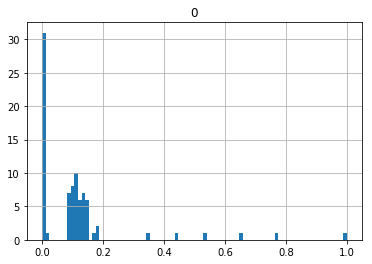

In [19]:
df_missing_values.hist(bins=85)

In [20]:
df_missing_values['missing'] = sum_values_missing

In [21]:
df_missing_values.columns = ["percentage_missing", "total_missing"]

In [22]:
df_missing_values.sort_values(by='percentage_missing', inplace=True, ascending=False)

In [23]:
df_missing_values.head(50)

,percentage_missing,total_missing
TITEL_KZ,0.997576,889061
AGER_TYP,0.769554,685843
KK_KUNDENTYP,0.655967,584612
KBA05_BAUMAX,0.534687,476524
GEBURTSJAHR,0.440203,392318
ALTER_HH,0.348137,310267
KKK,0.177357,158064
REGIOTYP,0.177357,158064
W_KEIT_KIND_HH,0.166051,147988
KBA05_ANTG1,0.149597,133324


In [24]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias = azdias.drop(['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH'], axis=1)

In [25]:
# 6 columns dropped, columns are now 79
azdias.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

Dropped the top 6 columns. I'm guessing the number of columns to drop is up to the developer / stakeholder. The dropped percentages ranged from 35% to 99% and seemed to me as outliers as all the rest is under 18%

Dropped columns were TITEL_KZ, AGER_TYP, KK_KUNDENTYP, KBA05_BAUMAX, GEBURTSJAHR, ALTER_HH

My limited knowledge of German tells me that Geburtsjahr is date of birth, Alter is age. Both would seem to be private info that probably would have an option of not to disclose.

There seems to be set of columns that start with KBA05, and another that start with PLZ8. These could be locations? These sets have 13-15% missing data.

Most of the data have around 8-15% of missing data. No clear pattern to me.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [26]:
# How much data is missing in each row of the dataset?
null_rows = pd.DataFrame(azdias.isnull().sum(axis=1))
null_rows.columns = ["total_missing"]
null_rows.sort_values(by='total_missing', inplace=True, ascending=False)
null_rows.shape

(891221, 1)

In [27]:
null_rows.describe()

,total_missing
count,891221.000000
mean,5.649894
std,13.234687
min,0.000000
25%,0.000000
50%,0.000000
75%,3.000000
max,49.000000


In [28]:
null_rows.head(10)

,total_missing
732775,49
643174,49
472919,48
345274,47
299868,47
582092,47
681255,47
818343,47
582109,47
439981,47


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8a6ca52208>]], dtype=object)

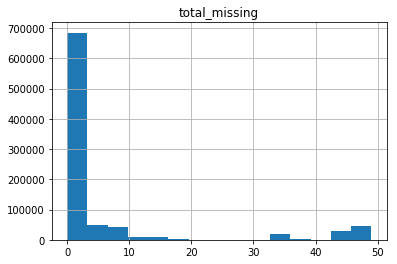

In [29]:
null_rows.hist(bins = 15)

This simple histogram shows us that around 70% of the rows contain 0-10 NULL values. There is a clear separation shown where some columns are shown to have 30-50 NULL values. If we were to drop rows, it would be at the 30 NULL values mark.

In [30]:
# We will add a column to azdias that holds the total of NULL values to each row
azdias['TOTAL_NULL'] = azdias.isnull().sum(axis=1)

In [31]:
azdias.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,TOTAL_NULL
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43
1,1.0,2,5.0,1,5,2,5,4,5,1,...,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,7
4,3.0,1,5.0,4,3,4,1,3,2,5,...,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0


In [32]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias_high_null = azdias[azdias.TOTAL_NULL >= 30].copy()
azdias_low_null = azdias[azdias.TOTAL_NULL < 30].copy()


In [33]:
azdias_high_null.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,TOTAL_NULL
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43
11,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47
14,3.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47
17,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47
24,3.0,2,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47


In [34]:
azdias_high_null.shape

(93160, 80)

In [35]:
azdias_low_null.shape

(798061, 80)

In [36]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
def plotting_function(df, column_name):
    fig = plt.figure(figsize=(20, 5))
    
    ax1 = fig.add_subplot(121)
    ax1.title.set_text('Incomplete')
    sns.countplot(df.loc[df.TOTAL_NULL >= 30, column_name])

    ax2 = fig.add_subplot(122)
    ax2.title.set_text('Complete')
    sns.countplot(df.loc[df.TOTAL_NULL < 30, column_name])

    fig.suptitle(column_name)
    plt.show();

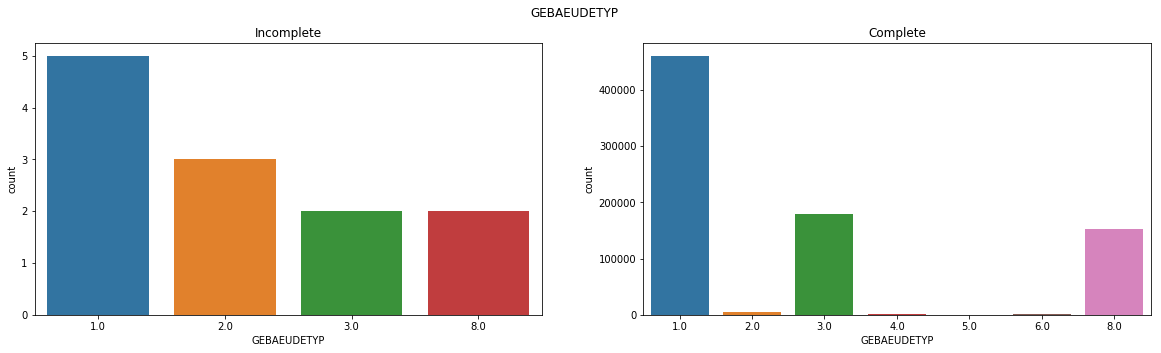

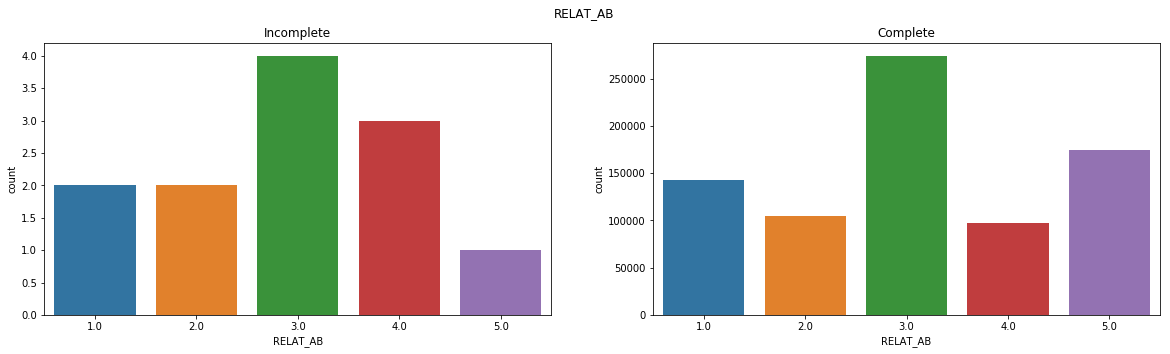

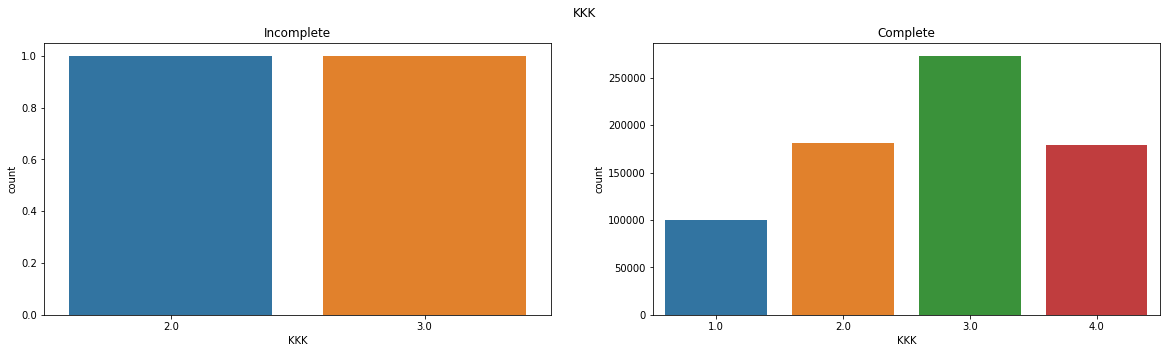

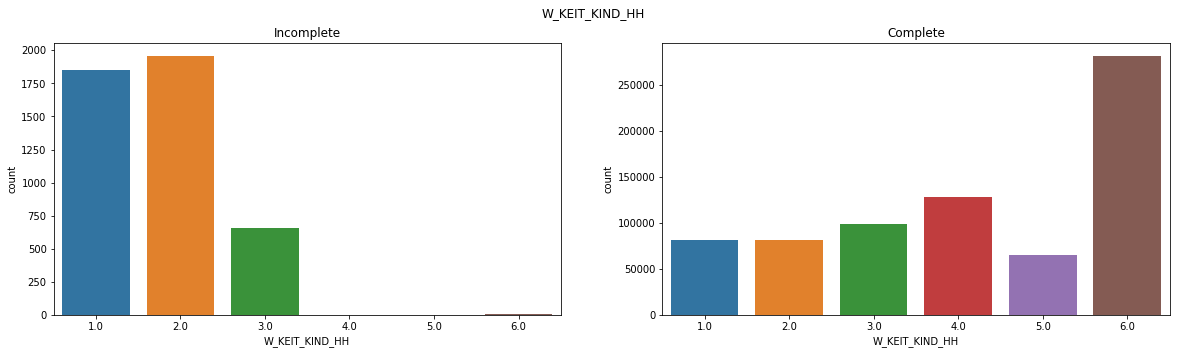

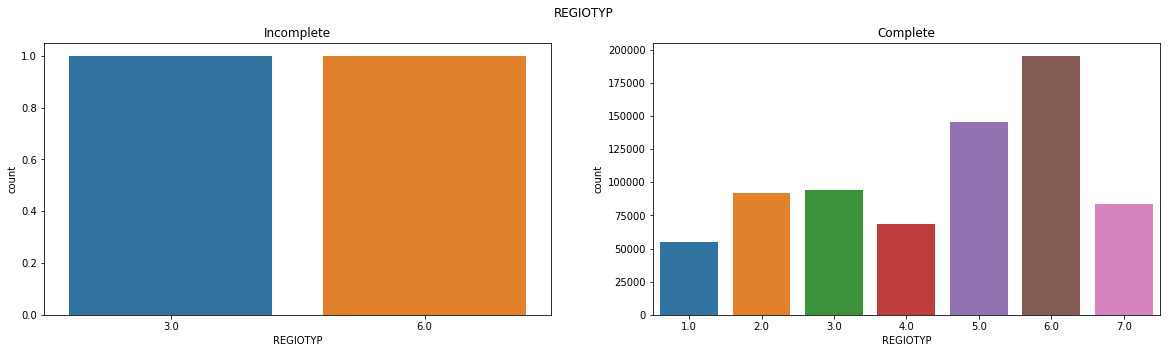

In [37]:
random_columns = ['GEBAEUDETYP', 'RELAT_AB', 'KKK', 'W_KEIT_KIND_HH', 'REGIOTYP']

for column in random_columns:
    plotting_function(azdias, column)

#### Discussion 1.1.3: Assess Missing Data in Each Row

Distributions for the complete and incomplete are quite different. There are values in the complete dataframe that are completly absent in the incomplete which confirms our assumption that the incomplete dataframe (higher than 30 NULLs) has many missing values enough to skew the data distribution of a column as seen in the previous cell.

It should also be noted that the Y axis is very different which is (I think, please let me know if I'm incorrect) just the count and that's fine since the df with NULL < 30 is smaller and has less rows.

Finally I will continue my analysis with the dataset that has few missing data azdias_low_null

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [38]:
# How many features are there of each data type?

categorical_df = pd.DataFrame(feat_info.loc[(feat_info['type'] == 'categorical')])
mixed_df = pd.DataFrame(feat_info.loc[(feat_info['type'] == 'mixed')])
print('categorical values datafram shape', categorical_df.shape)
print('mixed values datafram shape', mixed_df.shape)
                                            

categorical values datafram shape (21, 4)
mixed values datafram shape (7, 4)


In [39]:
list_of_categorical_values = categorical_df['attribute'].tolist()

#### we have 21 columns that are of type categorical, and 7 columns of type mixed

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [40]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

Titles_dropped_from_azdias = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']

list_of_categorical_values = [x for x in list_of_categorical_values if x not in Titles_dropped_from_azdias]

In [41]:
# We just dropped 4 values since they weren't in the dataframe we are working with anyway
len(list_of_categorical_values)

18

In [42]:
azdias_low_null[list_of_categorical_values].isnull().sum(axis=0)

ANREDE_KZ               0
CJT_GESAMTTYP        4745
FINANZTYP               0
GFK_URLAUBERTYP      4745
GREEN_AVANTGARDE        0
LP_FAMILIE_FEIN     31468
LP_FAMILIE_GROB     31468
LP_STATUS_FEIN       4745
LP_STATUS_GROB       4745
NATIONALITAET_KZ    33918
SHOPPER_TYP         36721
SOHO_KZ                 0
VERS_TYP            36721
ZABEOTYP                0
GEBAEUDETYP             0
OST_WEST_KZ             0
CAMEO_DEUG_2015      6198
CAMEO_DEU_2015       6198
dtype: int64

In [43]:
multivariates = []
binary_values = []
for x in list_of_categorical_values:
    if (azdias_low_null[x].nunique() > 2):
        multivariates.append(x)
    else:
        binary_values.append(x)
        

In [44]:
azdias_low_null[binary_values].nunique()

ANREDE_KZ           2
GREEN_AVANTGARDE    2
SOHO_KZ             2
VERS_TYP            2
OST_WEST_KZ         2
dtype: int64

In [45]:
for x in binary_values:
    print(azdias_low_null[x].unique())

[2 1]
[0 1]
[ 1.  0.]
[  2.   1.  nan]
['W' 'O']


In [46]:
azdias_low_null[binary_values].dtypes

ANREDE_KZ             int64
GREEN_AVANTGARDE      int64
SOHO_KZ             float64
VERS_TYP            float64
OST_WEST_KZ          object
dtype: object

In [47]:
azdias_low_null.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,TOTAL_NULL
1,1.0,2,5.0,1,5,2,5,4,5,1,...,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,7
4,3.0,1,5.0,4,3,4,1,3,2,5,...,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0


In [48]:
# transform floats to ints, and the W & O values to ints as well

azdias_low_null['VERS_TYP'].replace([2.0, 1.0], [1, 0], inplace=True)
azdias_low_null['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)

In [49]:
azdias_low_null['SOHO_KZ'] = azdias_low_null['SOHO_KZ'].round(0).astype(int)

In [50]:
# workaround for not allowing me to cast NULL to int in this float column

azdias_low_null['VERS_TYP'] = azdias_low_null['VERS_TYP'].fillna(-1)
azdias_low_null['VERS_TYP'] = azdias_low_null['VERS_TYP'].astype(int)
azdias_low_null['VERS_TYP'] = azdias_low_null['VERS_TYP'].replace('-1', np.nan)

In [51]:
azdias_low_null[binary_values].dtypes

ANREDE_KZ           int64
GREEN_AVANTGARDE    int64
SOHO_KZ             int64
VERS_TYP            int64
OST_WEST_KZ         int64
dtype: object

In [52]:
#binary transformation done
azdias_low_null[binary_values]

,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,VERS_TYP,OST_WEST_KZ
1,2,0,1,1,1
2,2,1,0,0,1
3,2,0,0,0,1
4,1,0,0,1,1
5,2,0,0,1,1
6,2,0,0,0,1
7,1,0,0,0,1
8,1,1,0,1,1
9,2,1,0,1,1
10,2,0,0,1,1


In [53]:
for x in multivariates:
    print(azdias_low_null[x].unique())

[  5.   3.   2.   4.   1.   6.  nan]
[1 6 5 2 4 3]
[ 10.   1.   5.  12.   9.   3.   8.  11.   4.   2.   7.   6.  nan]
[  5.   1.  nan  10.   2.   7.  11.   8.   4.   6.   9.   3.]
[  3.   1.  nan   5.   2.   4.]
[  2.   3.   9.   4.   1.  10.   5.   8.   6.   7.  nan]
[  1.   2.   4.   5.   3.  nan]
[  1.   3.   2.  nan]
[  3.   2.   1.   0.  nan]
[5 3 4 1 6 2]
[ 8.  1.  3.  2.  6.  4.  5.]
['8' '4' '2' '6' '1' '9' '5' '7' nan '3']
['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D' '9E'
 nan '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C' '9C'
 '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F' '5F' '1C']


In [54]:
azdias_low_null[multivariates].dtypes

CJT_GESAMTTYP       float64
FINANZTYP             int64
GFK_URLAUBERTYP     float64
LP_FAMILIE_FEIN     float64
LP_FAMILIE_GROB     float64
LP_STATUS_FEIN      float64
LP_STATUS_GROB      float64
NATIONALITAET_KZ    float64
SHOPPER_TYP         float64
ZABEOTYP              int64
GEBAEUDETYP         float64
CAMEO_DEUG_2015      object
CAMEO_DEU_2015       object
dtype: object

In [55]:
multivariate_df = azdias_low_null[multivariates]

In [56]:
multivariate_columns = list(multivariate_df.columns)
print("{} total features before one-hot encoding.".format(len(multivariate_columns)))
print(multivariate_columns)

13 total features before one-hot encoding.
['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [57]:
# Re-encode categorical variable(s) to be kept in the analysis.
multivariate_final = pd.get_dummies(multivariate_df)

In [58]:
encoded = list(multivariate_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))
print(encoded)

64 total features after one-hot encoding.
['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015_1', 'CAMEO_DEUG_2015_2', 'CAMEO_DEUG_2015_3', 'CAMEO_DEUG_2015_4', 'CAMEO_DEUG_2015_5', 'CAMEO_DEUG_2015_6', 'CAMEO_DEUG_2015_7', 'CAMEO_DEUG_2015_8', 'CAMEO_DEUG_2015_9', 'CAMEO_DEU_2015_1A', 'CAMEO_DEU_2015_1B', 'CAMEO_DEU_2015_1C', 'CAMEO_DEU_2015_1D', 'CAMEO_DEU_2015_1E', 'CAMEO_DEU_2015_2A', 'CAMEO_DEU_2015_2B', 'CAMEO_DEU_2015_2C', 'CAMEO_DEU_2015_2D', 'CAMEO_DEU_2015_3A', 'CAMEO_DEU_2015_3B', 'CAMEO_DEU_2015_3C', 'CAMEO_DEU_2015_3D', 'CAMEO_DEU_2015_4A', 'CAMEO_DEU_2015_4B', 'CAMEO_DEU_2015_4C', 'CAMEO_DEU_2015_4D', 'CAMEO_DEU_2015_4E', 'CAMEO_DEU_2015_5A', 'CAMEO_DEU_2015_5B', 'CAMEO_DEU_2015_5C', 'CAMEO_DEU_2015_5D', 'CAMEO_DEU_2015_5E', 'CAMEO_DEU_2015_5F', 'CAMEO_DEU_2015_6A', 'CAMEO_DEU_2015_6B', 'CAMEO_DEU_2015_6C', 'CAMEO_DEU_2015_

In [59]:
for x in multivariates:
    azdias_low_null.drop(x, axis = 1, inplace = True)

In [60]:
azdias_low_null = pd.concat([azdias_low_null, multivariate_final], axis=1)

In [61]:
azdias_low_null.shape

(798061, 131)

In [62]:
azdias_low_null.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,1,0,0,0,0,0,0,0,0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,0,0,0,0,0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0,0,0,0,0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,0,0,0,0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,1,0,0,0,0,0,0


#### Discussion 1.2.1: Re-Encode Categorical Features

We have converted all binary columns to int values. Next we encoded every multi variate column using One-hot encode. Finally we dropped all the original multivariate columns and combined the one hot encoded columns with the dataset. Now all categorical columns are ready to be processed by our algorithm. I opted to keep all these columns as not to lose the data. Dropping any or all of these columns if requested by the stakeholder is no issue as well. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [63]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
list_of_mixed_values = mixed_df['attribute'].tolist()
list_of_mixed_values = [x for x in list_of_mixed_values if x not in Titles_dropped_from_azdias]

In [64]:
len(list_of_mixed_values)

6

In [65]:
# We have six columns that are of mixed types to work with
azdias_low_null[list_of_mixed_values].head(20).T

,1,2,3,4,5,6,7,8,9,10,12,13,15,16,18,19,20,21,22,23
LP_LEBENSPHASE_FEIN,21,3,NaN,32,8,2,5,10,4,6,23,3,12,NaN,10,20,10,10,1,20
LP_LEBENSPHASE_GROB,6,1,NaN,10,2,1,2,3,1,2,6,1,3,NaN,3,5,3,3,1,5
PRAEGENDE_JUGENDJAHRE,14,15,8,8,3,10,8,11,15,3,8,15,5,14,10,9,11,10,14,9
WOHNLAGE,4,2,7,3,7,5,1,1,7,5,3,5,3,7,2,1,5,4,4,3
CAMEO_INTL_2015,51,24,12,43,54,22,14,13,15,51,43,33,41,41,24,34,24,55,51,43
PLZ8_BAUMAX,1,1,1,2,1,1,1,1,1,2,1,1,NaN,1,1,2,NaN,4,2,NaN


In [66]:
azdias_low_null[list_of_mixed_values].nunique()

LP_LEBENSPHASE_FEIN      40
LP_LEBENSPHASE_GROB      12
PRAEGENDE_JUGENDJAHRE    15
WOHNLAGE                  8
CAMEO_INTL_2015          21
PLZ8_BAUMAX               5
dtype: int64

In [67]:
# Looking at the data dictionary, we see what each value can indicate. I will create a function and feed the column to it to
# break down each value into AGE / Movement
def Praegende_to_Movement(value):
    try:
        if value in (1, 3, 5, 7, 9, 11, 13, 15):
            return 1
        elif value in (2, 4, 6, 8, 10, 12, 14):
            return 0
    except:
        return np.nan
    

def Jugendjahre_to_Age(value):
    try:
        if value in (1,2):
            return 40
        elif value in (3,4):
            return 50
        elif value in (5,6,7):
            return 60
        elif value in (8,9):
            return 70
        elif value in (10,11,12,13):
            return 80
        elif value in (14,15):
            return 90
    except:
        return np.nan

In [68]:
# Praegende_to_Movement returns 1 for mainstream and 0 for avantgarde
# Jugendjahre_to_Age returns 40, 50, 60, 70 ,80, 90 depending on the age group as mapped by the data dictionary 
azdias_low_null['MAPPED_MOVEMENT'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(Praegende_to_Movement)
azdias_low_null['MAPPED_AGE_GROUP'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(Jugendjahre_to_Age)

In [69]:
azdias_low_null.shape

(798061, 133)

In [70]:
azdias_low_null['MAPPED_AGE_GROUP'].head()

1    90.0
2    90.0
3    70.0
4    70.0
5    50.0
Name: MAPPED_AGE_GROUP, dtype: float64

In [71]:
age_group_df = azdias_low_null['MAPPED_AGE_GROUP']
age_group_final = pd.get_dummies(age_group_df)
age_group_final.head()

,40.0,50.0,60.0,70.0,80.0,90.0
1,0,0,0,0,0,1
2,0,0,0,0,0,1
3,0,0,0,1,0,0
4,0,0,0,1,0,0
5,0,1,0,0,0,0


In [72]:
age_group_final.columns = ['MAPPED_AGE_GROUP_40','MAPPED_AGE_GROUP_50','MAPPED_AGE_GROUP_60','MAPPED_AGE_GROUP_70','MAPPED_AGE_GROUP_80','MAPPED_AGE_GROUP_90']

In [73]:
# Here we one hot encode those newly encoded age groups and drop the column with values 40, 50, 60, ..
azdias_low_null.drop(['MAPPED_AGE_GROUP'], axis=1, inplace = True)
azdias_low_null = pd.concat([azdias_low_null, age_group_final], axis=1)

In [74]:
azdias_low_null.shape

(798061, 138)

In [75]:
# We drop PRAEGENDE_JUGENDJAHRE as we extracted the feature into MAPPED_MOVEMENT and the one hot encoded columns of age groups 
azdias_low_null.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1, inplace = True)

In [76]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
# Looking at the data dictionary, we will split each value in that column and process per digit 
azdias_low_null['CAMEO_INTL_2015'].unique()

array(['51', '24', '12', '43', '54', '22', '14', '13', '15', '33', '41',
       '34', '55', nan, '25', '23', '31', '52', '35', '45', '44', '32'], dtype=object)

In [77]:
def split_wealth(word): 
    # In case value is NaN
    if pd.isnull(word):
        return np.nan
    else:
        # Return first digit
        return int(str(word)[0])
    
def split_life_stage(word): 
    # In case value is NaN
    if pd.isnull(word):
        return np.nan
    else:
        # Return first digit
        return int(str(word)[1])

In [78]:
# We use two functions to split each CAMEO_INTL_2015 value to first digit and second digit and save in two new columns
azdias_low_null['MAPPED_WEALTH'] = azdias['CAMEO_INTL_2015'].apply(split_wealth)
azdias_low_null['MAPPED_LIFE_STAGE'] = azdias['CAMEO_INTL_2015'].apply(split_life_stage)

In [79]:
azdias_low_null.drop(['CAMEO_INTL_2015'], axis=1, inplace = True)

In [80]:
# We will one hot encode MAPPED_WEALTH
wealth_encoded_df = azdias_low_null['MAPPED_WEALTH']
wealth_encoded_final = pd.get_dummies(wealth_encoded_df)
wealth_encoded_final.head()

,1.0,2.0,3.0,4.0,5.0
1,0,0,0,0,1
2,0,1,0,0,0
3,1,0,0,0,0
4,0,0,0,1,0
5,0,0,0,0,1


In [81]:
wealth_encoded_final.columns = ['MAPPED_WEALTH_WEALTHY', 'MAPPED_WEALTH_PROSPEROUS', 'MAPPED_WEALTH_COMFORTABLE', 'MAPPED_WEALTH_LESSAFFLUENT', 'MAPPED_WEALTH_POORER']

In [82]:
azdias_low_null.drop(['MAPPED_WEALTH'], axis=1, inplace = True)
azdias_low_null = pd.concat([azdias_low_null, wealth_encoded_final], axis=1)

In [83]:
azdias_low_null.shape

(798061, 142)

In [84]:
# We will one hot encode MAPPED_LIFE_STAGE
lifestage_encoded_df = azdias_low_null['MAPPED_LIFE_STAGE']
lifestage_encoded_final = pd.get_dummies(lifestage_encoded_df)
lifestage_encoded_final.head()

,1.0,2.0,3.0,4.0,5.0
1,1,0,0,0,0
2,0,0,0,1,0
3,0,1,0,0,0
4,0,0,1,0,0
5,0,0,0,1,0


In [85]:
lifestage_encoded_final.columns = ['MAPPED_LIFESTAGE_PREFAMILY', 'MAPPED_LIFESTAGE_WCHILDREN', 'MAPPED_LIFESTAGE_SCHOOLCHILDREN', 'MAPPED_LIFESTAGE_MATURECOUPLES', 'MAPPED_LIFESTAGE_ELDERS']

In [86]:
azdias_low_null.drop(['MAPPED_LIFE_STAGE'], axis=1, inplace = True)
azdias_low_null = pd.concat([azdias_low_null, lifestage_encoded_final], axis=1)

In [87]:
azdias_low_null.shape

(798061, 146)

#### Discussion 1.2.2: Engineer Mixed-Type Features

We started with 6 mixed type features. I dropped the 4 that were not mentioned in this part of the project for simplicity as we need a function for almost each feature. The 2 that are mentioned, PRAEGENDE_JUGENDJAHRE & CAMEO_INTL_2015 are broken down into multiple columns that still perserve the data that existed in the original column. 

PRAEGENDE_JUGENDJAHRE indicates age group and movement. It also indicates location (W or E) but there are too many values to detangle. The age group was one hot encoded into 6 columns. MAPPED_AGE_GROUP_40, MAPPED_AGE_GROUP_50, all the way to 90.
The movement was engineered to column name MAPPED_MOVEMENT with odd numbers indicating Mainstream and even numbers indicating Avantgarde.

CAMEO_INTL_2015 was mapped on two axis, so we engineered for that two new columns. 
MAPPED_WEALTH, and MAPPED_LIFE_STAGE. We furthermore went and broke down each column into 5 columns by one hot encoding. Finally we dropped those 2 columns and added the 10 encoded columns

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [88]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
azdias_low_null.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP',
       ...
       'MAPPED_WEALTH_WEALTHY', 'MAPPED_WEALTH_PROSPEROUS',
       'MAPPED_WEALTH_COMFORTABLE', 'MAPPED_WEALTH_LESSAFFLUENT',
       'MAPPED_WEALTH_POORER', 'MAPPED_LIFESTAGE_PREFAMILY',
       'MAPPED_LIFESTAGE_WCHILDREN', 'MAPPED_LIFESTAGE_SCHOOLCHILDREN',
       'MAPPED_LIFESTAGE_MATURECOUPLES', 'MAPPED_LIFESTAGE_ELDERS'],
      dtype='object', length=146)

In [89]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [90]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...

    for attribute, missing_or_unknown in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
        if missing_or_unknown[0] != '':  
            for value in missing_or_unknown:
                if value.isnumeric() or value.lstrip('-').isnumeric():
                    value = int(value)
                df[attribute] = df[attribute].replace(value, np.nan)
    # at this point in the function, all missing values according to the df feat_info have been removed and replaced with NAN
    
    # remove selected columns and rows, ...
    # This drops the same columns we dropped previously in azdias
    df.drop(columns=Titles_dropped_from_azdias, axis=1, inplace = True)
    
    # This drops the rows that have high amount of NULL, we will go with 30+ NULLs as previously done
    df['TOTAL_NULL'] = df.isnull().sum(axis=1)
    df = df[azdias.TOTAL_NULL < 30].copy()
    
    # select, re-encode, and engineer column values.
    
    # start with binaries and multivariates
    binaries_multivariates_encoded = binaries_multivariates_reencode(df)
    
    for x in multivariates:
        df.drop(x, axis = 1, inplace = True)
        
    df = pd.concat([df, binaries_multivariates_encoded], axis=1)
    
    # move on to mixed type features
    
    df['MAPPED_MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].apply(Praegende_to_Movement)
    age_group_encoded = engineer_agegroup(df)
    
    df.drop(['MAPPED_AGE_GROUP'], axis=1, inplace = True)
    df.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1, inplace = True)
    df = pd.concat([df, age_group_encoded], axis=1)
    # PRAEGENDE_JUGENDJAHRE done
    
    wealth_encoded = engineer_wealth(df)
    df.drop(['MAPPED_WEALTH'], axis=1, inplace = True)
    # MAPPED_WEALTH done
    
    lifestage_encoded = engineer_lifestage(df)
    df.drop(['MAPPED_LIFE_STAGE'], axis=1, inplace = True)
    # MAPPED_LIFE_STAGE done
    
    df.drop(['CAMEO_INTL_2015'], axis=1, inplace = True)
    wealth_lifestage = pd.concat([wealth_encoded, lifestage_encoded], axis=1)
    df = pd.concat([df, wealth_lifestage], axis=1)
    # CAMEO_INTL_2015 done
    
    return df
    # Return the cleaned dataframe.
    
def binaries_multivariates_reencode(df):
    
    # first start with binary values
    # transform floats to ints, and the W & O values to ints as well
    df['VERS_TYP'].replace([2.0, 1.0], [1, 0], inplace=True)
    df['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)
    #df['SOHO_KZ'] = df['SOHO_KZ'].round(0).astype(int)
    
    # workaround for not allowing me to cast NULL to int in this float column
    df['SOHO_KZ'] = df['SOHO_KZ'].fillna(-1)
    df['SOHO_KZ'] = df['SOHO_KZ'].round(0).astype(int)
    df['SOHO_KZ'] = df['SOHO_KZ'].replace('-1', np.nan) 
    # workaround for not allowing me to cast NULL to int in this float column
    df['VERS_TYP'] = df['VERS_TYP'].fillna(-1)
    df['VERS_TYP'] = df['VERS_TYP'].astype(int)
    df['VERS_TYP'] = df['VERS_TYP'].replace('-1', np.nan)   
    
    #next we move on to multivariates
    multivariate_df = df[multivariates]
    multivariate_final = pd.get_dummies(multivariate_df)
    
    return multivariate_final


def engineer_agegroup(df):
    
    df['MAPPED_AGE_GROUP'] = df['PRAEGENDE_JUGENDJAHRE'].apply(Jugendjahre_to_Age)
    
    age_group_df = df['MAPPED_AGE_GROUP']
    age_group_final = pd.get_dummies(age_group_df)
    
    age_group_final.columns = ['MAPPED_AGE_GROUP_40','MAPPED_AGE_GROUP_50','MAPPED_AGE_GROUP_60','MAPPED_AGE_GROUP_70','MAPPED_AGE_GROUP_80','MAPPED_AGE_GROUP_90']
        
    return age_group_final

def engineer_wealth(df):
    
    df['MAPPED_WEALTH'] = df['CAMEO_INTL_2015'].apply(split_wealth)
    
    wealth_encoded_df = df['MAPPED_WEALTH']
    wealth_encoded_final = pd.get_dummies(wealth_encoded_df)
    
    wealth_encoded_final.columns = ['MAPPED_WEALTH_WEALTHY', 'MAPPED_WEALTH_PROSPEROUS', 'MAPPED_WEALTH_COMFORTABLE', 'MAPPED_WEALTH_LESSAFFLUENT', 'MAPPED_WEALTH_POORER']
    
    return wealth_encoded_final

def engineer_lifestage(df):
    
    df['MAPPED_LIFE_STAGE'] = df['CAMEO_INTL_2015'].apply(split_life_stage)
    
    lifestage_encoded_df = df['MAPPED_LIFE_STAGE']
    lifestage_encoded_final = pd.get_dummies(lifestage_encoded_df)
    
    lifestage_encoded_final.columns = ['MAPPED_LIFESTAGE_PREFAMILY', 'MAPPED_LIFESTAGE_WCHILDREN', 'MAPPED_LIFESTAGE_SCHOOLCHILDREN', 'MAPPED_LIFESTAGE_MATURECOUPLES', 'MAPPED_LIFESTAGE_ELDERS']
    
    return lifestage_encoded_final


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [91]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
azdias_low_null.isnull().sum().sort_values(ascending=False)[:45]


REGIOTYP                64906
KKK                     64906
W_KEIT_KIND_HH          59302
LP_LEBENSPHASE_FEIN     50233
LP_LEBENSPHASE_GROB     47340
KBA05_GBZ               40164
MOBI_REGIO              40164
KBA05_ANTG1             40164
KBA05_ANTG2             40164
KBA05_ANTG3             40164
KBA05_ANTG4             40164
HEALTH_TYP              36721
SHOPPER_TYP             36721
NATIONALITAET_KZ        33918
LP_FAMILIE_GROB         31468
LP_FAMILIE_FEIN         31468
MAPPED_MOVEMENT         28755
PLZ8_HHZ                23355
PLZ8_ANTG1              23355
PLZ8_ANTG2              23355
PLZ8_ANTG3              23355
PLZ8_ANTG4              23355
PLZ8_BAUMAX             23355
PLZ8_GBZ                23355
KBA13_ANZAHL_PKW        12641
ANZ_HAUSHALTE_AKTIV      6460
CJT_GESAMTTYP            4745
LP_STATUS_FEIN           4745
GFK_URLAUBERTYP          4745
LP_STATUS_GROB           4745
RETOURTYP_BK_S           4745
ONLINE_AFFINITAET        4745
RELAT_AB                 4227
ARBEIT    

In [92]:
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
azdias_imp = pd.DataFrame(imp.fit_transform(azdias_low_null))

In [93]:
azdias_imp.shape

(798061, 146)

In [94]:
# all nulls removed and instead used an imputer to replace with the mean
azdias_imp.isnull().sum().sort_values(ascending=False)[:5]

145    0
36     0
52     0
51     0
50     0
dtype: int64

In [95]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler()
azdias_imp_scaled = scaler.fit_transform(azdias_imp)
azdias_imp_scaled = pd.DataFrame(azdias_imp_scaled)

azdias_imp_scaled.columns = azdias_low_null.columns
azdias_imp_scaled.index = azdias_low_null.index

In [96]:
# Changing the name
azdias_final = azdias_imp_scaled
azdias_final.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,MAPPED_WEALTH_WEALTHY,MAPPED_WEALTH_PROSPEROUS,MAPPED_WEALTH_COMFORTABLE,MAPPED_WEALTH_LESSAFFLUENT,MAPPED_WEALTH_POORER,MAPPED_LIFESTAGE_PREFAMILY,MAPPED_LIFESTAGE_WCHILDREN,MAPPED_LIFESTAGE_SCHOOLCHILDREN,MAPPED_LIFESTAGE_MATURECOUPLES,MAPPED_LIFESTAGE_ELDERS
1,-1.766064,0.957914,-1.494594,1.537924,-1.040692,1.465965,0.958645,1.339314,-0.530409,1.085947,...,-0.419532,-0.560315,-0.305664,-0.558912,1.602945,1.502227,-0.327485,-0.420049,-0.641705,-0.414566
2,0.201243,0.957914,-1.494594,0.864563,-1.766980,-0.570998,0.244119,1.339314,1.885336,1.085947,...,-0.419532,1.784710,-0.305664,-0.558912,-0.623852,-0.665678,-0.327485,-0.420049,1.558349,-0.414566
3,1.184897,0.957914,0.683144,-0.482158,1.138172,-0.570998,-1.184933,-0.791205,-0.530409,-0.269817,...,2.383606,-0.560315,-0.305664,-0.558912,-0.623852,-0.665678,3.053578,-0.420049,-0.641705,-0.414566
4,0.201243,-1.043935,0.683144,0.191203,0.411884,-1.249985,0.244119,-0.791205,-0.530409,1.085947,...,-0.419532,-0.560315,-0.305664,1.789191,-0.623852,-0.665678,-0.327485,2.380677,-0.641705,-0.414566
5,-1.766064,0.957914,-0.042768,-1.155518,1.138172,-0.570998,-0.470407,1.339314,-0.530409,1.085947,...,-0.419532,-0.560315,-0.305664,-0.558912,1.602945,-0.665678,-0.327485,-0.420049,1.558349,-0.414566


### Discussion 2.1: Apply Feature Scaling

The missing data by column is less than 10% at most. There are 43 columns that contain NULL values. This does not seem to me enough to drop the rows. I will be using an imputer to replace the NULL values with the mean of each column. Finally we used standard scalar on all of the data. This means that the values will all be between -1 and 1 with a mean of 0. I will be working with azdias_final now

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [97]:
# Apply PCA to the data.
# Not setting a number of features will result in keeping all the features
pca = PCA()
pca.fit(azdias_final)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

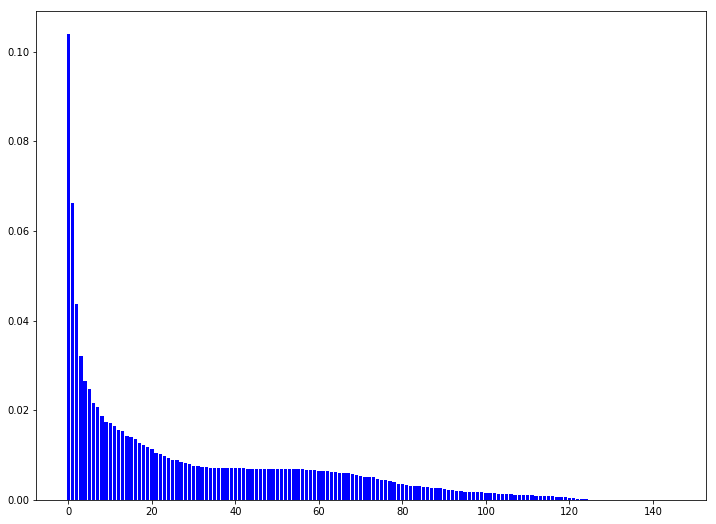

In [98]:
# Investigate the variance accounted for by each principal component.

num_components=len(pca.explained_variance_ratio_)

comp = np.arange(num_components)
values = pca.explained_variance_ratio_

fig, ax = plt.subplots(figsize=(12,9))
plt.bar(comp, values, color='b');


In [99]:
# We could eyeball the figure and pull a relativly good number to do PCA at, but I will create a loop
# that will print out how much variance does a number of columns hold
for i in np.arange(10, 121, 10):
    print('{} components contain {} of variance.'.format(i, pca.explained_variance_ratio_[:i].sum()))

10 components contain 0.37539088432350876 of variance.
20 components contain 0.5184752327622683 of variance.
30 components contain 0.6117772477456229 of variance.
40 components contain 0.6840600251638782 of variance.
50 components contain 0.7536235378053331 of variance.
60 components contain 0.821720464000661 of variance.
70 components contain 0.8825489200675191 of variance.
80 components contain 0.9284594016634264 of variance.
90 components contain 0.9583216264835676 of variance.
100 components contain 0.9774917297755511 of variance.
110 components contain 0.9907547695109824 of variance.
120 components contain 0.9987551131215896 of variance.


In [100]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca = PCA(n_components=80)
azdias_pca = pca.fit_transform(azdias_final)

### Discussion 2.2: Perform Dimensionality Reduction

We started with a dataframe that had 147 columns. I choose to use 80 values for PCA. This is around half of the original number, it might take too much time, but it gives us over 90# of the original dataset. I will continue with this number, if it seems to be too taxing to compute I will choose a lower value

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [101]:
# Listing and plotting function
def plotting_pca_components(df, pca, component_no, features_no):
    
    # Build a dataframe with features_no features capturing most variability
    # for a given component number (component_no)
    pca_comp = pd.DataFrame(pca.components_, columns=df.keys()).iloc[component_no - 1]
    pca_comp.sort_values(ascending=False, inplace=True)
    pca_comp = pd.concat([pca_comp.head(features_no), pca_comp.tail(features_no)])
    
    # Plot the result
    pca_comp.plot(kind='bar', 
              title='Most {} weighted features for PCA component {}'.format(features_no*2, component_no),
              figsize=(12, 6))
    plt.show()
    
    return pca_comp

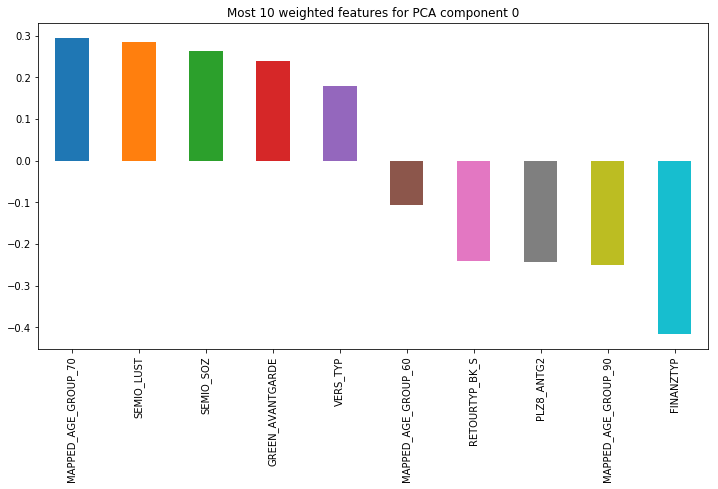

MAPPED_AGE_GROUP_70    0.295136
SEMIO_LUST             0.284999
SEMIO_SOZ              0.263288
GREEN_AVANTGARDE       0.238911
VERS_TYP               0.180453
MAPPED_AGE_GROUP_60   -0.105216
RETOURTYP_BK_S        -0.240106
PLZ8_ANTG2            -0.243013
MAPPED_AGE_GROUP_90   -0.250494
FINANZTYP             -0.416449
Name: 79, dtype: float64


In [102]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

res = plotting_pca_components(azdias_final, pca, 0, 5)
print(res)

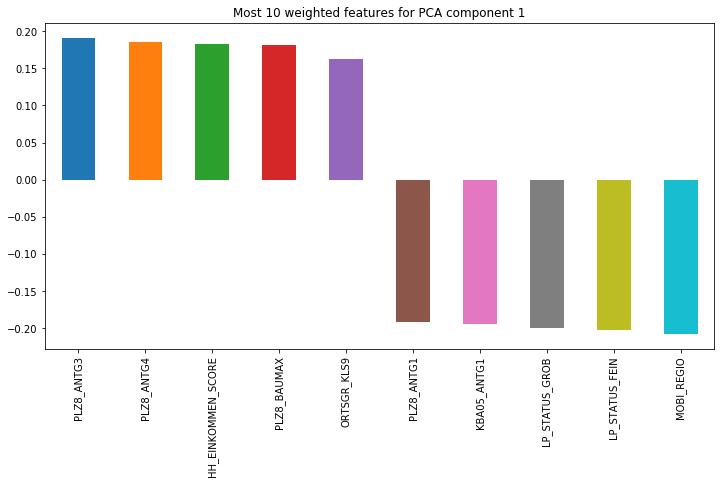

PLZ8_ANTG3            0.191383
PLZ8_ANTG4            0.185382
HH_EINKOMMEN_SCORE    0.183249
PLZ8_BAUMAX           0.181149
ORTSGR_KLS9           0.163188
PLZ8_ANTG1           -0.191883
KBA05_ANTG1          -0.193771
LP_STATUS_GROB       -0.199754
LP_STATUS_FEIN       -0.202892
MOBI_REGIO           -0.207774
Name: 0, dtype: float64


In [103]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

res = plotting_pca_components(azdias_final, pca, 1, 5)
print(res)

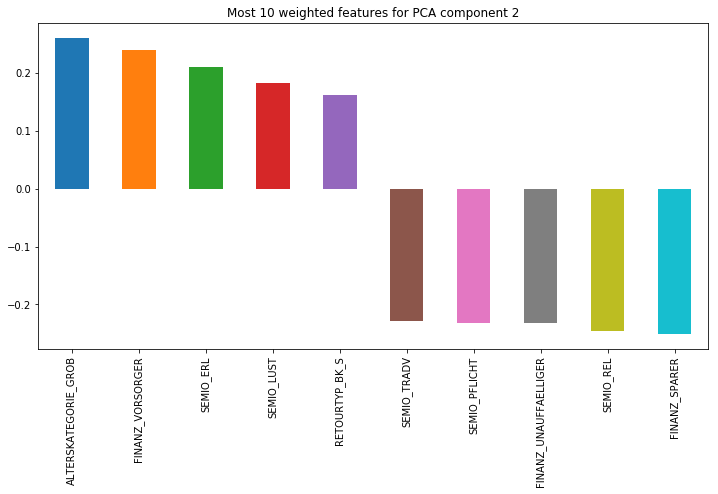

ALTERSKATEGORIE_GROB     0.261277
FINANZ_VORSORGER         0.239063
SEMIO_ERL                0.209707
SEMIO_LUST               0.182517
RETOURTYP_BK_S           0.161870
SEMIO_TRADV             -0.228005
SEMIO_PFLICHT           -0.231728
FINANZ_UNAUFFAELLIGER   -0.232594
SEMIO_REL               -0.246453
FINANZ_SPARER           -0.251167
Name: 1, dtype: float64


In [104]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

res = plotting_pca_components(azdias_final, pca, 2, 5)
print(res)

### Discussion 2.3: Interpret Principal Components


First PCA component is positively affected by the following 5 columns:

1- FINANZTYP                translates to: Financial typology          

2- MAPPED_AGE_GROUP_90      translates to: Age group encoded column, whether person is born in the 90s or not 

3- PLZ8_ANTG2               translates to: Number of 3-5 family houses in the PLZ8 region 

4- RETOURTYP_BK_S           translates to: Return type 

5- MAPPED_AGE_GROUP_60      translates to: Age group encoded column, whether person is born in the 60s or not 

Those 5 columns are highly influenced by the first vector, Finanztyp which is the financial type of an individual. The other vectors all combined have less weight that the first one, so it probably means that this first component is mostly dependandt on this one vector (Finanztyp) and is trying to describe a person's financial habits and clustering like minded individuals together

Second PCA component is positively affected by the following 5 columns:         

1- PLZ8_ANTG3               translates to: Number of 6-10 family houses in the PLZ8 region 

2- PLZ8_ANTG4               translates to: Number of 10+ family houses in the PLZ8 region

3- HH_EINKOMMEN_SCORE       translates to: Estimated household net income

4- PLZ8_BAUMAX              translates to: Most common building type within the PLZ8 region 

5- ORTSGR_KLS9              translates to: Size of community

Those 5 columns influences are spread evenly between all 5. When looked at together seem to capture some sort of population density in the PLZ8 region, and the number of inhabitants and each household's net income. 

Third PCA component is positively affected by the following 5 columns:

1- ALTERSKATEGORIE_GROB     translates to: Estimated age based on given name analysis

2- FINANZ_VORSORGER         translates to: Financial typology - be prepared

3- SEMIO_ERL                translates to: Personality typology - event oriented

4- SEMIO_LUST               translates to: Personality typology - sensual minded

5- RETOURTYP_BK_S           translates to: Return type

Those 5 columns seem to describe more personal traits of an individual. They describe a personal financial traits, age, and personality type when it comes to events or even senuality. 

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [436]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.

# DO NOT RUN THIS AGAIN!! 

scores = [] # Sum of Squared Errors
number_clusters = np.arange(10, 31)

for num in number_clusters:
    # Run k-means clustering on the return of the pca dimension reduction
    kmeans = KMeans(n_clusters=num, n_jobs=-1).fit(azdias_pca)
    # Compute the average within-cluster distances
    score = np.abs(kmeans.score(azdias_pca))
    scores.append(score)
    print('Clustering done for {} k, with SSE {}'.format(num, score))

Clustering done for 10 k, with SSE 84070212.16997182
Clustering done for 11 k, with SSE 83259279.68996926
Clustering done for 12 k, with SSE 81243228.05251619
Clustering done for 13 k, with SSE 80320881.8144316
Clustering done for 14 k, with SSE 79657330.10500097
Clustering done for 15 k, with SSE 78560592.18582976
Clustering done for 16 k, with SSE 77476616.35560687
Clustering done for 17 k, with SSE 76369480.79947424
Clustering done for 18 k, with SSE 75493684.6764933
Clustering done for 19 k, with SSE 74572281.91405693
Clustering done for 20 k, with SSE 73779354.74512252
Clustering done for 21 k, with SSE 72753569.99399035
Clustering done for 22 k, with SSE 71671513.9608774
Clustering done for 23 k, with SSE 70753443.27370366
Clustering done for 24 k, with SSE 70035636.51663567
Clustering done for 25 k, with SSE 68498458.64383556
Clustering done for 26 k, with SSE 67868008.57810022
Clustering done for 27 k, with SSE 67264879.12231588
Clustering done for 28 k, with SSE 66593285.90499

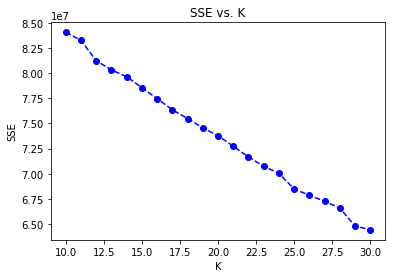

In [437]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(number_clusters, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [116]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans_azdias = KMeans(25, n_jobs=-1).fit(azdias_pca)
population_clusters = kmeans_azdias.predict(azdias_pca)
score = np.abs(kmeans.score(azdias_pca))
print('Clustering done for {} k, with SSE {}'.format(25, score))

Clustering done for 25 k, with SSE 81613557.4217974


### Discussion 3.1: Apply Clustering to General Population

As shown in the figure, the SSE relation to the increase of clusters seems mostly linear. It is not as clear as the examples in the lessons with an elbow figure, and maybe we need to increase the number of clusers to see something as drastic as that? I will select 25 clusters for now as there seems to be a very slight tapering off there.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [106]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [107]:
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [108]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers = clean_data(customers)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [109]:
customers.shape

(171504, 146)

In [110]:
# imputing
customers_imp = pd.DataFrame(imp.transform(customers))


In [111]:
# feature scaling

customers_imp_scaled = scaler.transform(customers_imp)
customers_imp_scaled = pd.DataFrame(customers_imp_scaled)

customers_imp_scaled.columns = customers.columns
customers_imp_scaled.index = customers.index

In [112]:
# dimensionality reduction

customers_pca = pca.transform(customers_imp_scaled)

In [117]:
# Clustering

kmeans_customer = KMeans(25, n_jobs=-1).fit(customers_pca)
customers_clusters = kmeans_customer.predict(customers_pca)
score = np.abs(kmeans.score(customers_pca))
print('Clustering done for {} k, with SSE {}'.format(25, score))

Clustering done for 25 k, with SSE 10544663.445296993


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [136]:
population_clusters = pd.Series(population_clusters)
population_cluster_count = population_clusters.value_counts().sort_index()
population_cluster_count = pd.Series(population_cluster_count)

In [137]:
customers_clusters = pd.Series(customers_clusters)
customer_cluster_count = customers_clusters.value_counts().sort_index()
customer_cluster_count = pd.Series(customer_cluster_count)

In [140]:
# Create a dataset summarizing clustering information
cluster_comparison = pd.concat([population_cluster_count, customer_cluster_count], axis=1).reset_index()
cluster_comparison.columns = ['cluster', 'population', 'customers']


# Calculate proprotions
cluster_comparison['cust_prop'] = cluster_comparison['customers'] / cluster_comparison['customers'].sum()
cluster_comparison['pop_prop'] = cluster_comparison['population'] / cluster_comparison['population'].sum()
cluster_comparison



,cluster,population,customers,cust_prop,pop_prop
0,0,20542,41634,0.242758,0.025740
1,1,13709,6175,0.036005,0.017178
2,2,79301,6176,0.036011,0.099367
3,3,56672,13151,0.076680,0.071012
4,4,30992,12457,0.072634,0.038834
5,5,36303,6606,0.038518,0.045489
6,6,16971,3865,0.022536,0.021265
7,7,33154,10623,0.061940,0.041543
8,8,54683,4503,0.026256,0.068520
9,9,13249,9801,0.057147,0.016601


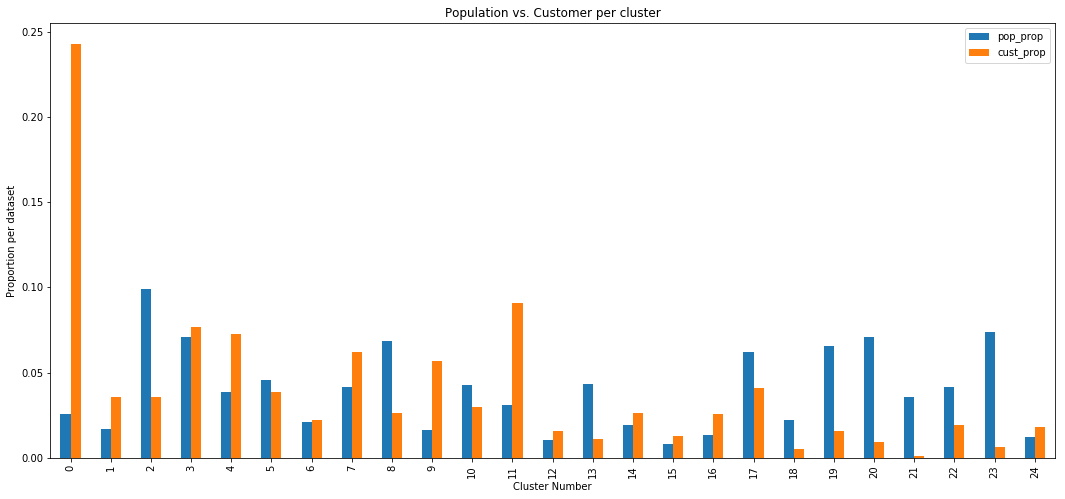

In [142]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

cluster_comparison.plot(x='cluster', y=['pop_prop', 'cust_prop'], kind='bar', figsize=(18, 8))
plt.title('Population vs. Customer per cluster')
plt.xlabel('Cluster Number')
plt.ylabel('Proportion per dataset')
plt.show()

In [148]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# An example for that would be cluster 0 

clust_0 = kmeans_customer.cluster_centers_[0]
# print('PCA values \n', clust_0)

clust_0 = pd.Series(clust_0)
clust_0.sort_values(ascending=False, inplace=True)
clust_0.head(5)

17    5.039952
14    4.039176
12    3.351247
21    2.396298
26    2.262743
dtype: float64

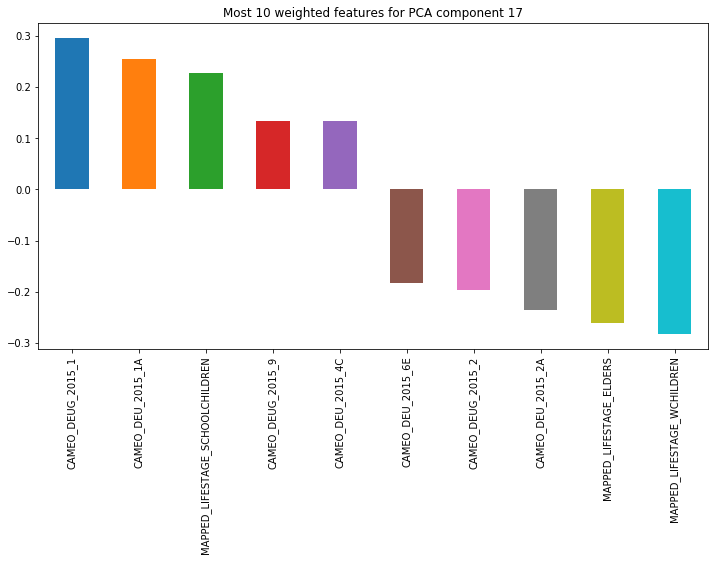

CAMEO_DEUG_2015_1                  0.296341
CAMEO_DEU_2015_1A                  0.254260
MAPPED_LIFESTAGE_SCHOOLCHILDREN    0.227417
CAMEO_DEUG_2015_9                  0.134578
CAMEO_DEU_2015_4C                  0.133152
CAMEO_DEU_2015_6E                 -0.182175
CAMEO_DEUG_2015_2                 -0.196515
CAMEO_DEU_2015_2A                 -0.235416
MAPPED_LIFESTAGE_ELDERS           -0.261221
MAPPED_LIFESTAGE_WCHILDREN        -0.282984
Name: 16, dtype: float64


In [149]:
res = plotting_pca_components(customers, pca, 17, 5)
print(res)

In [161]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# An example for that would be cluster 20 

clust_23 = kmeans_azdias.cluster_centers_[23]
# print('PCA values \n', clust_23)

clust_23 = pd.Series(clust_23)
clust_23.sort_values(ascending=False, inplace=True)
clust_23.head(5)

4     1.443859
16    1.154978
19    1.055100
14    0.856773
37    0.802914
dtype: float64

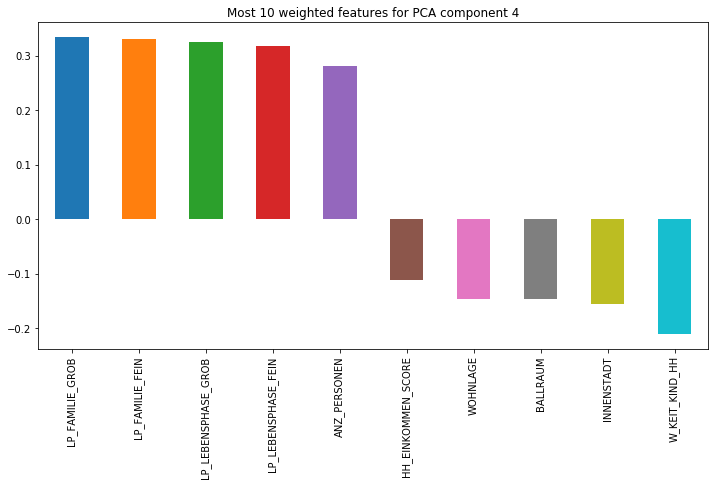

LP_FAMILIE_GROB        0.333787
LP_FAMILIE_FEIN        0.331310
LP_LEBENSPHASE_GROB    0.324395
LP_LEBENSPHASE_FEIN    0.316801
ANZ_PERSONEN           0.280348
HH_EINKOMMEN_SCORE    -0.111400
WOHNLAGE              -0.146338
BALLRAUM              -0.146392
INNENSTADT            -0.155107
W_KEIT_KIND_HH        -0.210552
Name: 3, dtype: float64


In [165]:
res = plotting_pca_components(azdias_final, pca, 4, 5)
print(res)

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

I first looked at cluster 0 which is represented in the customers cluster much more than the general population cluster. I looked at the highest PCA component that has the highest effect on this cluster and found the following:

1- Component 17 was the highest effecting PCA, it is broken down into the following:
    1.1- CAMEO_DEUG_2015_1: Upper class
    1.2- CAMEO_DEU_2015_1A: Work-Life-Balance
    1.3- MAPPED_LIFESTAGE_SCHOOLCHILDREN: This is an engineered column by me, it refers to Families With School Age Children
    1.4- CAMEO_DEUG_2015_9: urban working class
    1.5- CAMEO_DEU_2015_4C: String trimmer
    
I am not sure what a string trimmer is, but it seems that the customers would be represented by these characteristics as people who have money to spend. A young, rich family, that strives for work life balance and lives and works in the city. I would infer by that that the product is a luxury item that is aimed to make life easier for a busy family.

Next I looked at cluster 20 which is represented in the general population cluster much more than the customer cluster. I looked at the highest PCA component that has the highest effect on this cluster and found the following:

1- Component 0 was the highest effecting PCA, it is broken down into the following:
    1.1- LP_FAMILIE_GROB: Family type, rough scale
    1.2- LP_FAMILIE_FEIN: Family type, fine scale
    1.3- LP_LEBENSPHASE_GROB: Life stage, rough scale
    1.4- LP_LEBENSPHASE_FEIN: Life stage, fine scale
    1.5- ANZ_PERSONEN: Number of adults in household
    
For some reason I don't see results on these columns...I think I will need help with this one

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.